# Matrix factorization

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../')

from pathlib import Path

import pandas as pd
import torch
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from src.models.matrix_factorization import MatrixFactorization, train
from src.util.data import get_interactions, get_sparsity_factor
from src.util.plot import Plot

plot = Plot()

RATINGS_PATH = Path('../data/ratings_small.csv')
OUTPUT_PATH = Path('../models/matrix-factorization.pt')

## Data

In [2]:
ratings = pd.read_csv(RATINGS_PATH)

In [3]:
user_encoder = LabelEncoder()
user_encoder.fit(ratings['userId'].values)

movie_encoder = LabelEncoder()
movie_encoder.fit(ratings['movieId'].values)

LabelEncoder()

In [4]:
train_ratings, test_ratings = train_test_split(
    ratings,
    test_size=0.05,
    stratify=ratings['userId'].values,
    random_state=42
)

In [5]:
train_interactions = get_interactions(
    train_ratings,
    user_encoder,
    movie_encoder
)

test_interactions = get_interactions(
    test_ratings,
    user_encoder,
    movie_encoder
)

Building interaction matrix: 100%|██████████| 5001/5001 [00:00<00:00, 1249744.66it/s]


In [6]:
train_sparsity = get_sparsity_factor(train_interactions)
test_sparsity = get_sparsity_factor(test_interactions)

In [7]:
print(f'Train sparsity: {(train_sparsity * 100):.3f}%')
print(f'Test sparsity: {(test_sparsity * 100):.3f}%')

Train sparsity: 1.562%
Test sparsity: 0.082%


## Model

In [8]:
model = MatrixFactorization(
    train_interactions,
    n_factors=20,
    user_encoder=user_encoder,
    movie_encoder=movie_encoder,
)

In [9]:
train_loss_history, test_loss_history = train(
    model,
    train_interactions,
    test_interactions,
    epochs=500,
    batch_size=5000,
)

Training: 100%|██████████| 500/500 [07:40<00:00,  1.09it/s]


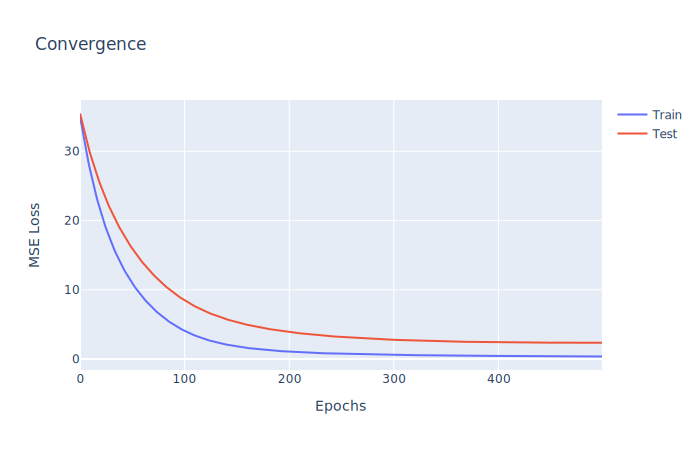

In [10]:
plot.convergence(
    losses=[train_loss_history, test_loss_history],
    names=['Train', 'Test']
)

In [11]:
torch.save(model, OUTPUT_PATH)